<a href="https://colab.research.google.com/github/jasonwashburn/VWGeojsonViewer/blob/main/VW_GeoJSON_Viewer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install folium -U

In [25]:
import os
import json
import folium
from folium.features import GeoJsonPopup, GeoJsonTooltip
import ipywidgets as widgets
import geopandas as gpd

In [3]:
product_properties = {
    'icing': {
        'color_property': 'intensity',
        'extents': ['base', 'top'],
        'color_property_values': {
            'Lgt-Rime': "#CC945C",
            'Lgt-Mixed': "#86E656",
            'Lgt-Clear': "#DD99FF",
            'Mdt-Rime': "#664524",
            'Mdt-Mixed': "#00AA00",
            'Mdt-Clear': "#FF55FF",
            'Svr-Rime': "#CC7722",
            'Svr-Mixed': "#0088AA",
            'Svr-Clear': "#FF0000",
        }
    },
    'turbulence': {
        'color_property': 'intensity',
        'extents': ['base', 'top'],
        'color_property_values': {
            'LGT': "#9C9C9C",
            'LGT-MDT': "#99CCFF",
            'MDT': "#3333FF",
            'MDT-SVR': "#FFFF00",
            'SVR': "#FF0000",
            'SVR-XTRM': "#FF77FF",
            'XTRM': "#9911FF",
            'SVR-MWV': "#FF8200" # Super obvious orange since type not implemented yet
        }
    },
    'TStorms': {
        'color_property': 'coverage',
        'extents': ['top'],
        'color_property_values': {
            'ISOLD': "#33FF00",
            'FEW': "#FFFF00",
            'SCT': "#FF6600",
            'NMRS': "#FF0000",
        }
    }   
}


In [4]:
def build_geojson_filepath_list(path="./geojson/") -> list:
    files = os.listdir(path)
    geojson_files = [path + file for file in files if ".json" in file]
    return geojson_files

def build_geojson_file_list(path="./geojson/") -> list:
    files = os.listdir(path)
    geojson_files = [file for file in files if ".json" in file]
    return geojson_files

def list_geojson_files(path="./geojson") -> None:
    for i, geojson_file in enumerate(build_geojson_filepath_list()):
        print(f"{i}: {geojson_file}")

def load_geojson_file(file) -> dict:
    with open(file, 'r') as data:
        json_data = json.loads(data.read())
    return json_data

def get_product_type(file) -> str:
    json_data = load_geojson_file(file)
    if json_data['features'][0]['properties']['feature_type']:
        return json_data['features'][0]['properties']['feature_type']

def get_product_feature_properties(file) -> str:
    json_data = load_geojson_file(file)
    if json_data['features'][0]['properties']:
        return json_data['features'][0]['properties']  

def style_function(feature) -> dict:
    feature_type = feature['properties']['feature_type']
    feature_properties = feature['properties']
    if feature_type == 'icing':
        color_lookup_value = feature_properties['intensity'] + '-' + feature_properties['type']
    elif feature_type == 'TStorms':
        color_lookup_value = feature_properties['coverage']
    elif feature_type == 'turbulence':
        color_lookup_value = feature_properties['intensity']

    color_code = product_properties[feature_type]['color_property_values'][color_lookup_value]
    return { 
        'fillColor': color_code,
        'fillOpacity': 0.6,
        'lineOpacity': 1,
        'weight': .5
    }

def build_geojson_map(geojson_file):
    geojson_data = load_geojson_file(geojson_file)
    geojson_properties = get_product_feature_properties(geojson_file)

    tooltip = GeoJsonTooltip(
        fields=[prop for prop in geojson_properties],
        localize=True,
        sticky=False,
        labels=True,
        style="""
            background-color: #F0EFEF;
            border: 2px solid blue;
            border-radius: 10px;
            box-shadow: 3px;
        """,
    )

    popup = GeoJsonPopup(
        fields=[prop for prop in geojson_properties],
        localize=True,
        labels=True,
        style="""
            background-color: #F0EFEF;
            border: 2px solid blue;
            border-radius: 10px;
            box-shadow: 3px;
        """,
    )


    m = folium.Map(location=[0,0],zoom_start=2, min_zoom=1, zoom_snap=0.25, max_bounds=True, box_zoom=True, max_bounds_viscosity=0.9, width="90%", height="80%")
    folium.GeoJson(data=geojson_data, tooltip=tooltip, popup=popup, style_function=style_function).add_to(m)

    return m

def dropdown_file_selection_eventhandler(change):
    global selected_file
    selected_file = build_geojson_filepath_list()[change.new]
    output_map.clear_output()
    with output_map:
        m = build_geojson_map(selected_file)
        display(m)

def btn_refresh_files_eventhandler(event):
    dropdown_file_selection.options = [(filenum, file) for (file, filenum) in enumerate(build_geojson_file_list())]

selected_file = ""
    
btn_refresh_files = widgets.Button(description="Refresh List")
btn_refresh_files.on_click(btn_refresh_files_eventhandler)
output_map = widgets.Output()
dropdown_file_selection = widgets.Dropdown(options=[(filenum, file) for (file, filenum) in enumerate(build_geojson_file_list())], description="Select File:")
dropdown_file_selection.observe(dropdown_file_selection_eventhandler, names="value")


In [5]:
display( dropdown_file_selection, btn_refresh_files)

Dropdown(description='Select File:', options=(('FITL_LLICG_2021052115Z.json', 0), ('FITL_LLTURB_2021052203Z.js…

Button(description='Refresh List', style=ButtonStyle())

In [6]:
display(output_map)

Output()

In [244]:
import pandas as pd
from matplotlib import cm
import matplotlib.pyplot as plt

In [26]:
geojson_file = selected_file

In [83]:
gpd_df = gpd.read_file(geojson_file)
df = pd.DataFrame(gpd_df)

In [84]:
df.head()

,coverage,top,feature_id,feature_type,geometry
0,ISOLD,225.0,1,TStorms,"POLYGON ((31.39680 64.62500, 30.52120 63.75000..."
1,ISOLD,350.0,2,TStorms,"POLYGON ((40.90341 64.62500, 40.40306 64.12500..."
2,ISOLD,350.0,3,TStorms,"POLYGON ((46.90757 64.37500, 46.53231 64.00000..."
3,ISOLD,300.0,4,TStorms,"POLYGON ((33.64838 63.12500, 33.77345 62.25000..."
4,ISOLD,300.0,5,TStorms,"POLYGON ((39.40236 61.62500, 39.52746 61.25000..."


In [28]:
df['coverage'].unique()

array(['ISOLD', 'FEW', 'SCT', 'NMRS'], dtype=object)

In [49]:
df.count()

coverage        235
top             235
feature_id      235
feature_type    235
geometry        235
dtype: int64

In [47]:
counts_df = df.groupby('coverage').nunique()

In [59]:
df['coverage'].value_counts()

ISOLD    117
FEW       94
SCT       23
NMRS       1
Name: coverage, dtype: int64

array([<AxesSubplot:ylabel='top'>], dtype=object)

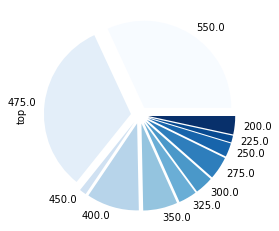

In [240]:
df['top'].value_counts().sort_index(ascending=False).plot.pie(subplots=True, 
                                                              cmap='Blues',
                                                              figsize=(8, 4), 
                                                              explode=[0.1 for value in df['top'].value_counts()],
                                                              startangle=0)

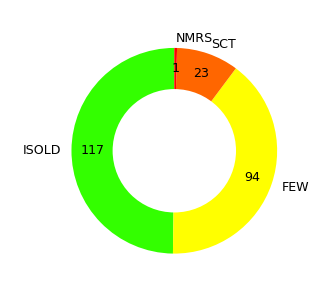

In [330]:
# df['coverage'].value_counts().plot.pie(startangle=45,
#                                        subplots=True, 
#                                        figsize=(8, 4), 
#                                        explode=[0.1 for value in df['coverage'].value_counts()], 
#                                        colors=[colors[i] for i in coverage_df.index])

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{v:d}'.format(v=val)
    return my_autopct

plt.figure(figsize=(1.5,1.5), dpi=227)
plt.pie(df['coverage'].value_counts(), autopct=make_autopct(df['coverage'].value_counts()), labels=df['coverage'].value_counts().keys(), textprops={'fontsize': 4}, startangle=90, pctdistance=0.8, colors=[colors[i] for i in coverage_df.index])

# draw circle
center_circle = plt.Circle((0,0), radius=0.6, fc='white')
plt.gca().add_artist(center_circle)
plt.show()

<AxesSubplot:>

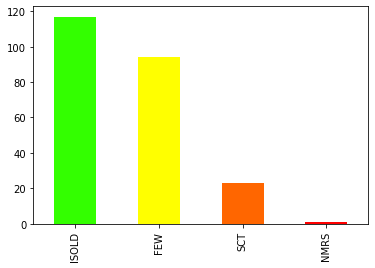

In [100]:
colors = product_properties['TStorms']['color_property_values']
df['coverage'].value_counts().plot.bar(color=[colors[i] for i in coverage_df.index])


<AxesSubplot:title={'center':'Distribution of Coverage by Tops'}, xlabel='top'>

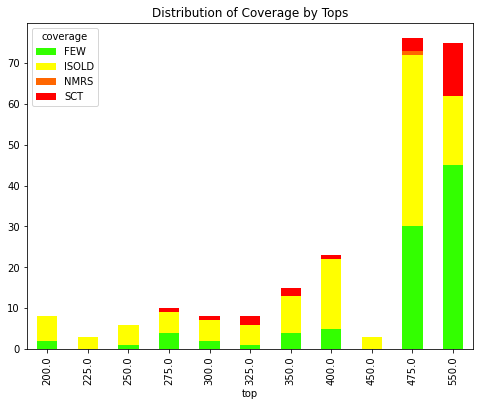

In [329]:
s = df.groupby('top')['coverage'].value_counts()
s.unstack().plot.bar(figsize=(8, 6),title="Distribution of Coverage by Tops", stacked=True, color=[colors[i] for i in coverage_df.index])

#df[['top', 'coverage']].value_counts().sort_index().plot.bar(stacked=True)

In [95]:
colors

{'ISOLD': '#33FF00', 'FEW': '#FFFF00', 'SCT': '#FF6600', 'NMRS': '#FF0000'}

In [92]:
product_properties['TStorms']['color_property_values']['SCT']

'#FF6600'

In [97]:
[colors[i] for i in coverage_df.index]

['#33FF00', '#FFFF00', '#FF6600', '#FF0000']

,coverage,top,feature_id,feature_type,geometry
0,ISOLD,225.0,1,TStorms,"POLYGON ((31.39680 64.62500, 30.52120 63.75000..."
1,ISOLD,350.0,2,TStorms,"POLYGON ((40.90341 64.62500, 40.40306 64.12500..."
2,ISOLD,350.0,3,TStorms,"POLYGON ((46.90757 64.37500, 46.53231 64.00000..."
3,ISOLD,300.0,4,TStorms,"POLYGON ((33.64838 63.12500, 33.77345 62.25000..."
4,ISOLD,300.0,5,TStorms,"POLYGON ((39.40236 61.62500, 39.52746 61.25000..."
...,...,...,...,...,...
230,SCT,400.0,231,TStorms,"POLYGON ((-11.38291 -27.12500, -12.00834 -27.5..."
231,SCT,275.0,232,TStorms,"POLYGON ((44.40584 -38.37500, 44.28076 -39.750..."
232,SCT,325.0,233,TStorms,"POLYGON ((-20.13898 -38.62500, -20.38916 -40.6..."
233,SCT,325.0,234,TStorms,"POLYGON ((-17.38708 -40.12500, -17.76234 -40.7..."


In [24]:
gpd_df[gpd_df["coverage"] == "ISOLD"].count()[0]

117

In [108]:
import seaborn as sns

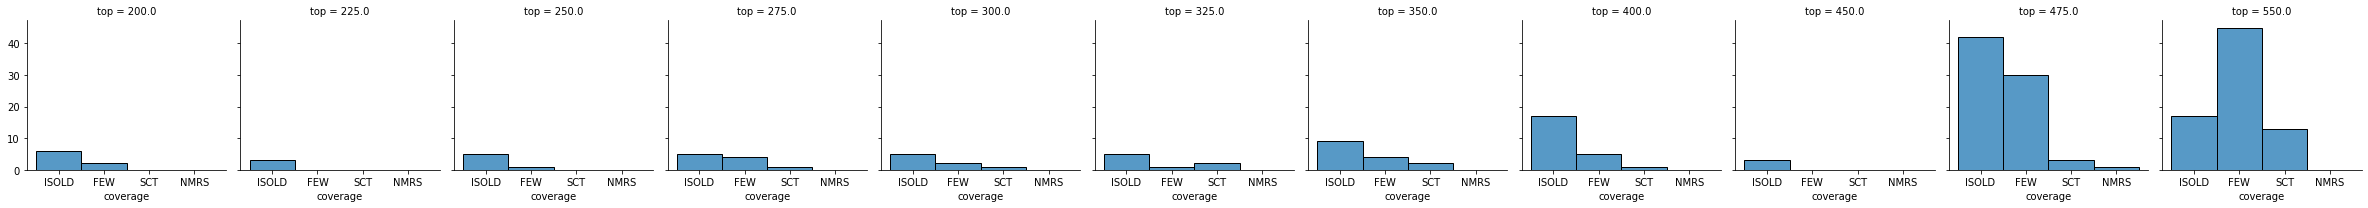

In [118]:
g = sns.FacetGrid(df, col='top')
g.map(sns.histplot, "coverage")


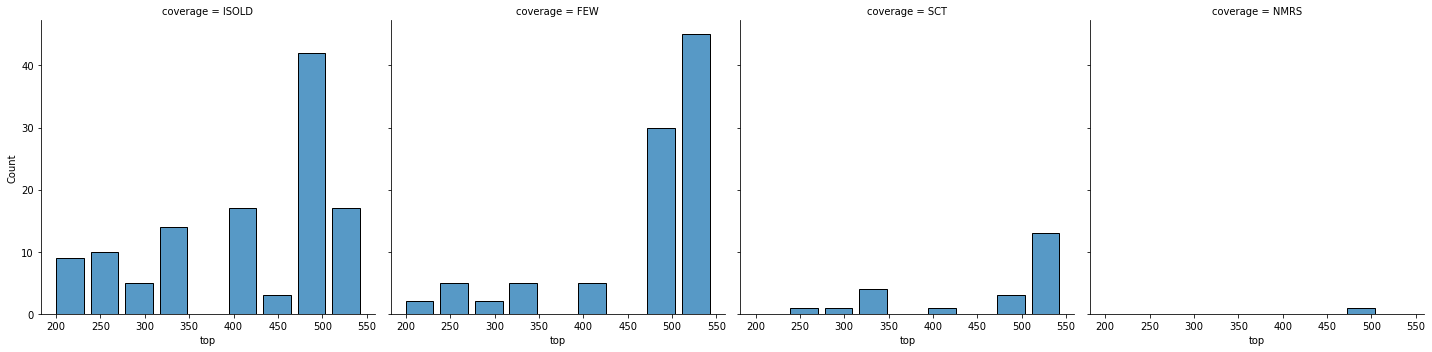

In [160]:
sns.displot(data=df, x='top', col='coverage', shrink=.8)

In [156]:
top_list = [bin for bin in df['top'].unique()].sort()
top_list.sort()
top_list

[200.0, 225.0, 250.0, 275.0, 300.0, 325.0, 350.0, 400.0, 450.0, 475.0, 550.0]

In [315]:
df['coverage'].value_counts().keys()

Index(['ISOLD', 'FEW', 'SCT', 'NMRS'], dtype='object')